In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import glob #read multiple files
import warnings
warnings.filterwarnings("ignore")
#display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import master_functions as mf

# I. Import and transoform option data

In [6]:
option_data = mf.import_data("option_data")
# make a copy of the original data

merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2016.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2020.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2017.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2011.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2012.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2013.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2014.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Option_data/delta_hedging_ATM_c_m30_all_2018.xlsx
merge /Users/edgarschmidt/Deskto

In [7]:
help(mf.transform_strikeprice)
option_data_copy = pd.DataFrame(option_data.copy())
option_data_copy = mf.transform_strikeprice(option_data_copy)

Help on function transform_strikeprice in module master_functions:

transform_strikeprice(option_data)
    The original data source has exported a wrong format for the strike price. 
    This function transforms the strike price into the correct format.



In [8]:
help(mf.calculate_optionprice_C)
option_data_copy = mf.calculate_optionprice_C(option_data_copy)

Help on function calculate_optionprice_C in module master_functions:

calculate_optionprice_C(option_data)
    Later, in the delta-gain-hedge calculation, we need the option price C. 
    This function calculates the option price C as the middle price of best bid and best offer.



In [9]:
help(mf.filter_option_data_30_days_before_maturity)
option_data_copy = mf.filter_option_data_30_days_before_maturity(option_data_copy)

Help on function filter_option_data_30_days_before_maturity in module master_functions:

filter_option_data_30_days_before_maturity(option_data)
    We are only interested in the observations 30 days before maturity. 
    The other observations are not relevant for our analysis and are therefore deleted.

Shape before transformation:  (9080229, 16)
Shape after transformation:  (5961046, 16)


In [10]:
help(mf.delete_options_with_more_than_x_missings)
option_data_copy = mf.delete_options_with_more_than_x_missings(option_data_copy, 6)

Help on function delete_options_with_more_than_x_missings in module master_functions:

delete_options_with_more_than_x_missings(option_data, x)
    Missing Delta values are indicated with a value of -99,x. This function deletes all options that have more than x missing values.

Number of deleted options:  25549


In [11]:
help(mf.replace_missings)
option_data_copy = mf.replace_missings(option_data_copy)

Help on function replace_missings in module master_functions:

replace_missings(option_data)
    If we have less then 7 missing values, we can replace the missing values with the value of the previous day. 
    If there is no previous day, then we are using the next day.



In [12]:
option_data_copy.shape

(5391029, 16)

# II. Calculate Delta-Hedged-Gains

In [13]:
help(mf.calculate_discrete_delta_hedged_gains)
delta_gain_returns = mf.calculate_discrete_delta_hedged_gains(option_data_copy)

Help on function calculate_discrete_delta_hedged_gains in module master_functions:

calculate_discrete_delta_hedged_gains(option_data)
    Calculate Delta-Hedged-Gain-Return for each OptionID in the dataset.
    Return all results in a new table called "delta_gain_table".
    
    // This implementation uses vectorized operations, which can significantly speed up the calculation 15min -> 1min



In [14]:
delta_gain_returns.head()

,OptionID,SecurityID,Strike,maturity,delta_gain
0,34416330,102456,126.0,2011-06-17,0.003814
1,34615388,108226,40.0,2012-01-20,-0.029430
2,34615427,101795,30.0,2012-01-20,-0.028304
3,34615534,107532,35.0,2012-01-20,-0.004845
4,34615564,112487,50.0,2012-01-20,-0.012296


# III. Calculate Idiosyncratic Stock Volatility

In [15]:
stock_data = mf.import_data("stock_data")

merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_140000_06_2012_2014.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_112000_2018_2023.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_105000_2014_2016.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_140000_2018_2023.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_105000_2017_2023.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_rest_2000_2014.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securities_112000_08_2012_2014.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock_data/securties_rest_2015_10_2017.xlsx
merge /Users/edgarschmidt/Desktop/Masterarbeit/Datasource/Excel_Export/Stock

In [16]:
stock_data.head()

,SecurityID,Datum,ClosePrice,TotalReturn,mkt,SMB,HML,WML
0,112000,2012-06-01,7.30,-0.024064,-0.0260,-0.0053,0.0006,0.0001
1,112000,2012-06-04,7.00,-0.041096,-0.0005,0.0014,-0.0059,0.0043
2,112000,2012-06-05,7.05,0.007143,0.0068,0.0024,0.0017,-0.0097
3,112000,2012-06-06,7.15,0.014184,0.0232,0.0004,0.0028,-0.0099
4,112000,2012-06-07,7.23,0.011189,-0.0010,-0.0047,0.0021,0.0042


In [17]:
final_dataset = delta_gain_returns.sort_values(by=['SecurityID','maturity'], ascending=[True,True])

In [18]:
help(mf.calculate_volatilitys)
final_dataset = mf.calculate_volatilitys(final_dataset,stock_data)

Help on function calculate_volatilitys in module master_functions:

calculate_volatilitys(option_data, stock_data)
    Calculate volatilitys for each OptionID in the dataset.
    Return all results in a new table called "volatility_table".

Dimension after transofrmation:  (2509, 6269)
Dimension: (11323542, 4)
Dimension after dropping duplicates:  (2509, 4)


In [20]:
final_dataset = final_dataset.dropna()

# IV. Fama-MacBeth-Regression

In [21]:
help(mf.descriptive_statistics)
mf.descriptive_statistics(final_dataset)

Help on function descriptive_statistics in module master_functions:

descriptive_statistics(option_data)
    This function calculates the descriptive statistics for the option data.



,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,220533.0,-0.000955,0.067076,-4.659014e+00,-0.047301,-0.021838,-0.004011,0.014595,0.045340,4.668170
security_variance,220533.0,0.004428,0.034340,5.548191e-08,0.000450,0.000876,0.001904,0.004282,0.008890,11.827467
security_std_dev,220533.0,0.124233,0.093915,5.512594e-04,0.049619,0.069280,0.102113,0.153147,0.220659,8.048708
idiosyncratic_volatility,220533.0,0.000668,0.006135,6.917966e-11,0.000047,0.000101,0.000241,0.000595,0.001336,2.257320
systematic_volatility,220533.0,0.003760,0.028392,4.728263e-08,0.000391,0.000760,0.001645,0.003675,0.007593,9.570148
systematic_part_percent,220533.0,86.357239,4.738871,7.261000e+01,81.160000,82.360000,85.280000,89.400000,93.410000,100.000000


In [22]:
help(mf.final_regression)
mf.final_regression(final_dataset,True)

Help on function final_regression in module master_functions:

final_regression(option_data, constant)
    This function calculates the regression of the delta-gain-hedge (dependend variable) on the idiosyncratic volatility and the systematic volatility (independent variables).

                            OLS Regression Results                            
Dep. Variable:             delta_gain   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     120.9
Date:                Sun, 10 Sep 2023   Prob (F-statistic):           3.32e-53
Time:                        13:07:44   Log-Likelihood:             2.8306e+05
No. Observations:              220533   AIC:                        -5.661e+05
Df Residuals:                  220530   BIC:                        -5.661e+05
Df Model:                           2                                         
Covarianc

,0
const,-0.000655
idiosyncratic_volatility,0.048855
systematic_volatility,-0.088301


To be discussed: 
Paper says: 
- "delta-hedged equity option return decreases monotonically with an increase in the idiosyncratic volatility of the underlying stock" p.1
- "the coefficient on idiosyncratic volatility remains negative and significant" p.2
- "Total volatility (VOL) is the standard deviation of daily stock returns" Table 1
- "delta-hedged option return is negatively related to the total volatility of the underlying stock, measured as the std.dev of daily stock returns." p.8 
- The VOL coefficient estimate in this situation in the paper is -0.0299; mine is -0.027797 (Table 2)
- "IVOL is in the paper defined as the standard deviation of the resioduals of the Fama-French 3-factors model estimated using the daily stock returns over the previous month" Table 1
- "Systematic Volatility is defined as sqrt(VOL^2 - IVOL^2)" p.9
- "All volatility measures are annualized" <- Wurzel-T-Gesetz reicht aus? Table 2

# V. Appendix

##### Descriptive statistics sorted by idiosyncratic volatility

In [34]:
sorted_low_first = final_dataset.sort_values(by=['idiosyncratic_volatility'], ascending=[True]).head(int(0.20*len(final_dataset)))
sorted_high_first = final_dataset.sort_values(by=['idiosyncratic_volatility'], ascending=[False]).head(int(0.20*len(final_dataset)))

In [35]:
mf.descriptive_statistics(sorted_low_first)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,40551.0,0.002054,0.032224,-6.519033e-01,-0.022228,-0.010820,-0.001408,0.009770,0.027302,0.821364
security_variance,40551.0,0.002828,0.088198,1.601625e-07,0.000517,0.000863,0.001314,0.002059,0.003462,13.732328
security_std_dev,40551.0,0.161233,0.136841,1.591349e-03,0.090372,0.116798,0.144117,0.180450,0.233956,14.735236
idiosyncratic_volatility,40551.0,0.087365,0.038006,0.000000e+00,0.020181,0.069818,0.098933,0.116855,0.126141,0.132064
systematic_volatility,40551.0,0.123109,0.143140,4.152226e-04,0.039762,0.067355,0.103079,0.147950,0.210650,14.735236
systematic_part_percent,40551.0,71.503597,22.058309,5.200000e-01,39.210000,58.185000,75.060000,88.690000,99.250000,100.000000


In [36]:
mf.descriptive_statistics(sorted_high_first)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,40551.0,-0.009595,0.106748,-4.659014,-0.090349,-0.044867,-0.012322,0.020523,0.066431,4.314043
security_variance,40551.0,0.036375,0.097555,0.009751,0.013074,0.016219,0.022979,0.036456,0.060581,11.825019
security_std_dev,40551.0,0.685197,0.325030,0.392660,0.454663,0.506404,0.602773,0.759220,0.978706,13.673696
idiosyncratic_volatility,40551.0,0.606885,0.303514,0.391637,0.411512,0.445694,0.522877,0.662331,0.871053,12.095869
systematic_volatility,40551.0,0.280879,0.189252,0.000469,0.092801,0.153887,0.243173,0.360251,0.510752,6.376512
systematic_part_percent,40551.0,40.460286,18.497887,0.110000,16.260000,26.370000,39.740000,53.600000,65.560000,95.020000


In [37]:
mf.descriptive_statistics(final_dataset)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,202755.0,-0.000608,0.065272,-4.659014e+00,-0.046121,-0.021408,-0.003904,0.014582,0.045136,4.314043
security_variance,202755.0,0.011704,0.060239,1.601625e-07,0.001289,0.002490,0.005345,0.011874,0.024361,13.732328
security_std_dev,202755.0,0.350415,0.249522,1.591349e-03,0.142736,0.198401,0.290718,0.433293,0.620631,14.735236
idiosyncratic_volatility,202755.0,0.280649,0.227274,0.000000e+00,0.098933,0.146565,0.225214,0.351283,0.522876,12.095869
systematic_volatility,202755.0,0.183090,0.145302,1.399740e-04,0.056690,0.093812,0.149361,0.232431,0.345187,14.735236
systematic_part_percent,202755.0,54.710948,22.611567,8.000000e-02,23.640000,37.880000,55.380000,71.710000,84.310000,100.000000


In [38]:
# Create graph, that shows correlation betwenn delta_gain and security_variance in my dataframe final_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [251]:


correlation_matrix = final_dataset[['security_std_dev','idiosyncratic_volatility','systematic_volatility']].corr()
correlation_matrix

,security_std_dev,idiosyncratic_volatility,systematic_volatility
security_std_dev,1.000000,0.928441,0.726538
idiosyncratic_volatility,0.928441,1.000000,0.444444
systematic_volatility,0.726538,0.444444,1.000000


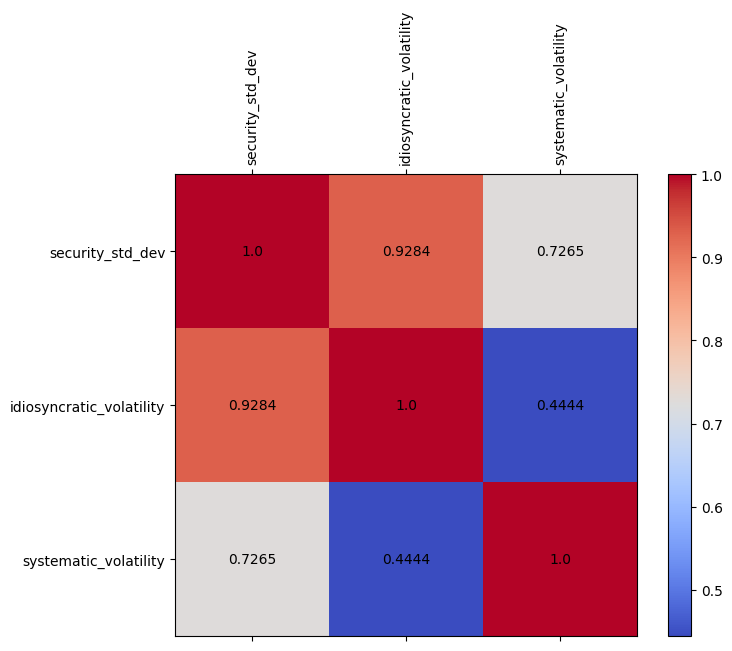

In [254]:
# Erstellen des Plots
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cax)

# Anzeigen der Korrelationskoeffizienten in den Feldern
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        ax.text(j, i, round(correlation_matrix.iloc[i, j], 4), ha='center', va='center')

# Achsentitel
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

plt.show()

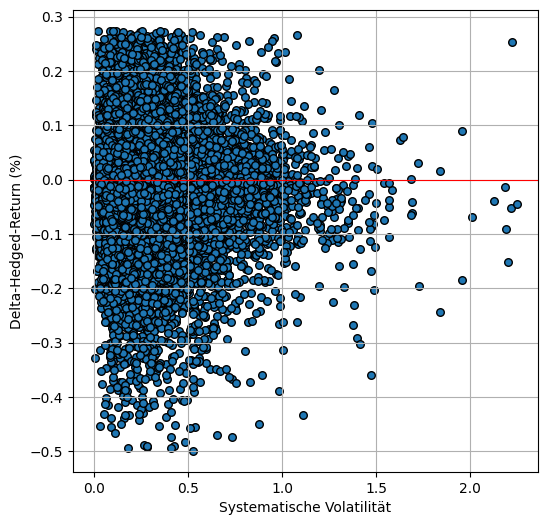

In [261]:
var_1 = 'delta_gain'
var_4 = 'Systematische Volatilität'
#var_3 = 'Delta-Hedged-Return in Abhängigkeit von der ' + ' var_of_interest'

var_2 = 'security_std_dev'
var_2 = 'idiosyncratic_volatility'
var_2 = 'systematic_volatility'

data_graph = final_dataset
data_graph = sorted_low_first
data_graph = sorted_high_first

filtered_dataset = data_graph[
    (data_graph[var_1] > data_graph[var_1].quantile(0.001)) & 
    (data_graph[var_1] < data_graph[var_1].quantile(0.99)) & 
    (data_graph[var_2] > data_graph[var_2].quantile(0.0001)) & 
    (data_graph[var_2] < data_graph[var_2].quantile(0.9999))
]
plt.figure(figsize=(6, 6))
plt.scatter(filtered_dataset[var_2],filtered_dataset[var_1], s=30, edgecolor='black')
#plt.title(var_3) 
plt.ylabel('Delta-Hedged-Return (%)')
plt.xlabel(var_4)
#plt.ylim(0, 1)
#plt.xlim(0, 1)
plt.grid(True)
plt.axhline(0, color='red', linewidth=0.8) 
plt.show()

# Model 1

In [292]:
def calculate_volatilitys(option_data,stock_data):
    """
    Calculate volatilitys for each OptionID in the dataset.
    Return all results in a new table called "volatility_table".
    """
    stock_returns   = mf.transform_stock_returns(stock_data)
    factor_returns  = mf.transform_market_factors(stock_data)
    #create new columns for volatilitys
    option_data['maturity_minus_60_days']   = option_data['maturity'] - pd.DateOffset(days=60)
    option_data['maturity_minus_30_days']   = option_data['maturity'] - pd.DateOffset(days=30)
    option_data['security_variance']        = None
    option_data['security_std_dev']         = None
    option_data['idiosyncratic_volatility'] = None
    option_data['systematic_volatility']    = None
    option_data['systematic_part_percent']  = None
    option_data['stock_data_available']     = False

    for i in range(len(option_data)):
        security_id = option_data['SecurityID'].iloc[i]
        start_time  = option_data.iloc[i,5]
        end_time    = option_data.iloc[i,6]
        delta_days = (end_time - start_time).days
        
        try:
            # filter stock returns and factor returns (between -60 and -30 days before maturity of the option_id)
            filtered_stock_returns  = stock_returns[security_id][(stock_returns.index >= start_time) & (stock_returns.index <= end_time)]
            filtered_factor_returns = factor_returns.iloc[:,0:2][(factor_returns.index >= start_time) & (factor_returns.index <= end_time)]

            # if len(filtered_stock_returns) == 0: skip and go to next i
            if len(filtered_stock_returns) == 0:
                continue

            # calculate regression with stock and market returns to get idiosyncratic volatility
            y = filtered_stock_returns
            y = y.reset_index(drop=True)

            X = filtered_factor_returns # market returns
            X = X.reset_index(drop=True)
            X = sm.add_constant(X)

            model = sm.OLS(y,X)
            results = model.fit()

            option_data.iloc[i,7]       = np.var(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,8]       = np.std(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,9]       = results.resid.std()*np.sqrt(250) # <-idiosyncratic volatility
            option_data.iloc[i,10]      = np.sqrt((option_data.iloc[i,8]**2 - option_data.iloc[i,9]**2))
            option_data.iloc[i,11]      = round(100*option_data.iloc[i,10]/option_data.iloc[i,8],2)
        except:
            option_data.iloc[i,12]      = True
    
    option_data['security_variance']        = option_data['security_variance'].astype(float)
    option_data['security_std_dev']         = option_data['security_std_dev'].astype(float)
    option_data['idiosyncratic_volatility'] = option_data['idiosyncratic_volatility'].astype(float)
    option_data['systematic_volatility']    = option_data['systematic_volatility'].astype(float)
    option_data['systematic_part_percent']  = option_data['systematic_part_percent'].astype(float)

    return option_data

In [293]:
final_dataset = delta_gain_returns.sort_values(by=['SecurityID','maturity'], ascending=[True,True])
final_dataset = calculate_volatilitys(final_dataset,stock_data)
final_dataset = final_dataset.dropna()
mf.final_regression(final_dataset,True)

Dimension after transofrmation:  (2509, 6269)
Dimension: (11323542, 4)
Dimension after dropping duplicates:  (2509, 4)
                            OLS Regression Results                            
Dep. Variable:             delta_gain   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     818.8
Date:                Wed, 13 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:17:42   Log-Likelihood:             2.6648e+05
No. Observations:              202755   AIC:                        -5.329e+05
Df Residuals:                  202752   BIC:                        -5.329e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975

,0
const,0.006649
idiosyncratic_volatility,-0.025589
systematic_volatility,-0.000415


In [294]:
mf.descriptive_statistics(final_dataset)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,202755.0,-0.000608,0.065272,-4.659014e+00,-0.046121,-0.021408,-0.003904,0.014582,0.045136,4.314043
security_variance,202755.0,0.011704,0.060239,1.601625e-07,0.001289,0.002490,0.005345,0.011874,0.024361,13.732328
security_std_dev,202755.0,0.350415,0.249522,1.591349e-03,0.142736,0.198401,0.290718,0.433293,0.620631,14.735236
idiosyncratic_volatility,202755.0,0.280649,0.227274,0.000000e+00,0.098933,0.146565,0.225214,0.351283,0.522876,12.095869
systematic_volatility,202755.0,0.183090,0.145302,1.399740e-04,0.056690,0.093812,0.149361,0.232431,0.345187,14.735236
systematic_part_percent,202755.0,54.710948,22.611567,8.000000e-02,23.640000,37.880000,55.380000,71.710000,84.310000,100.000000


# Model 2

In [295]:
def calculate_volatilitys(option_data,stock_data):
    """
    Calculate volatilitys for each OptionID in the dataset.
    Return all results in a new table called "volatility_table".
    """
    stock_returns   = mf.transform_stock_returns(stock_data)
    factor_returns  = mf.transform_market_factors(stock_data)
    #create new columns for volatilitys
    option_data['maturity_minus_60_days']   = option_data['maturity'] - pd.DateOffset(days=60)
    option_data['maturity_minus_30_days']   = option_data['maturity'] - pd.DateOffset(days=30)
    option_data['security_variance']        = None
    option_data['security_std_dev']         = None
    option_data['idiosyncratic_volatility'] = None
    option_data['systematic_volatility']    = None
    option_data['systematic_part_percent']  = None
    option_data['stock_data_available']     = False

    for i in range(len(option_data)):
        security_id = option_data['SecurityID'].iloc[i]
        start_time  = option_data.iloc[i,5]
        end_time    = option_data.iloc[i,6]
        delta_days = (end_time - start_time).days
        
        try:
            # filter stock returns and factor returns (between -60 and -30 days before maturity of the option_id)
            filtered_stock_returns  = stock_returns[security_id][(stock_returns.index >= start_time) & (stock_returns.index <= end_time)]
            filtered_factor_returns = factor_returns.iloc[:,0][(factor_returns.index >= start_time) & (factor_returns.index <= end_time)]

            # if len(filtered_stock_returns) == 0: skip and go to next i
            if len(filtered_stock_returns) == 0:
                continue

            # calculate regression with stock and market returns to get idiosyncratic volatility
            y = filtered_stock_returns
            y = y.reset_index(drop=True)

            X = filtered_factor_returns # market returns
            X = X.reset_index(drop=True)
            X = sm.add_constant(X)

            model = sm.OLS(y,X)
            results = model.fit()

            option_data.iloc[i,7]       = np.var(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,8]       = np.std(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,9]       = results.resid.std()*np.sqrt(250) # <-idiosyncratic volatility
            option_data.iloc[i,10]      = np.sqrt((option_data.iloc[i,8]**2 - option_data.iloc[i,9]**2))
            option_data.iloc[i,11]      = round(100*option_data.iloc[i,10]/option_data.iloc[i,8],2)
        except:
            option_data.iloc[i,12]      = True
    
    option_data['security_variance']        = option_data['security_variance'].astype(float)
    option_data['security_std_dev']         = option_data['security_std_dev'].astype(float)
    option_data['idiosyncratic_volatility'] = option_data['idiosyncratic_volatility'].astype(float)
    option_data['systematic_volatility']    = option_data['systematic_volatility'].astype(float)
    option_data['systematic_part_percent']  = option_data['systematic_part_percent'].astype(float)

    return option_data

In [296]:
final_dataset = delta_gain_returns.sort_values(by=['SecurityID','maturity'], ascending=[True,True])
final_dataset = calculate_volatilitys(final_dataset,stock_data)
final_dataset = final_dataset.dropna()
mf.final_regression(final_dataset,True)

Dimension after transofrmation:  (2509, 6269)
Dimension: (11323542, 4)
Dimension after dropping duplicates:  (2509, 4)
                            OLS Regression Results                            
Dep. Variable:             delta_gain   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     537.9
Date:                Wed, 13 Sep 2023   Prob (F-statistic):          1.19e-233
Time:                        09:21:27   Log-Likelihood:             2.4464e+05
No. Observations:              180221   AIC:                        -4.893e+05
Df Residuals:                  180218   BIC:                        -4.892e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975

,0
const,0.006078
idiosyncratic_volatility,-0.023156
systematic_volatility,0.000815


In [297]:
mf.descriptive_statistics(final_dataset)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,180221.0,-0.000256,0.062450,-4.659014e+00,-0.044101,-0.020790,-0.003765,0.014416,0.044302,4.314043
security_variance,180221.0,0.010613,0.049853,1.601625e-07,0.001287,0.002441,0.005146,0.011210,0.022696,13.732328
security_std_dev,180221.0,0.340143,0.228276,1.591349e-03,0.142666,0.196466,0.285246,0.421002,0.599050,14.735236
idiosyncratic_volatility,180221.0,0.279412,0.209761,1.315101e-04,0.103467,0.150527,0.227520,0.349488,0.514236,12.302913
systematic_volatility,180221.0,0.167750,0.132652,3.084851e-04,0.049901,0.084530,0.136388,0.212915,0.317971,11.823777
systematic_part_percent,180221.0,51.506765,22.860117,1.700000e-01,20.430000,33.930000,51.600000,68.900000,82.360000,100.000000


# Model 3

In [298]:
def calculate_volatilitys(option_data,stock_data):
    """
    Calculate volatilitys for each OptionID in the dataset.
    Return all results in a new table called "volatility_table".
    """
    stock_returns   = mf.transform_stock_returns(stock_data)
    factor_returns  = mf.transform_market_factors(stock_data)
    #create new columns for volatilitys
    option_data['maturity_minus_60_days']   = option_data['maturity'] - pd.DateOffset(days=60)
    option_data['maturity_minus_30_days']   = option_data['maturity'] - pd.DateOffset(days=30)
    option_data['security_variance']        = None
    option_data['security_std_dev']         = None
    option_data['idiosyncratic_volatility'] = None
    option_data['systematic_volatility']    = None
    option_data['systematic_part_percent']  = None
    option_data['stock_data_available']     = False

    for i in range(len(option_data)):
        security_id = option_data['SecurityID'].iloc[i]
        start_time  = option_data.iloc[i,5]
        end_time    = option_data.iloc[i,6]
        delta_days = (end_time - start_time).days
        
        try:
            # filter stock returns and factor returns (between -60 and -30 days before maturity of the option_id)
            filtered_stock_returns  = stock_returns[security_id][(stock_returns.index >= start_time) & (stock_returns.index <= end_time)]
            filtered_factor_returns = factor_returns.iloc[:,2][(factor_returns.index >= start_time) & (factor_returns.index <= end_time)]

            # if len(filtered_stock_returns) == 0: skip and go to next i
            if len(filtered_stock_returns) == 0:
                continue

            # calculate regression with stock and market returns to get idiosyncratic volatility
            y = filtered_stock_returns
            y = y.reset_index(drop=True)

            X = filtered_factor_returns # market returns
            X = X.reset_index(drop=True)
            X = sm.add_constant(X)

            model = sm.OLS(y,X)
            results = model.fit()

            option_data.iloc[i,7]       = np.var(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,8]       = np.std(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,9]       = results.resid.var()*np.sqrt(250) # <-idiosyncratic volatility
            option_data.iloc[i,10]      = option_data.iloc[i,7] - option_data.iloc[i,9]
            option_data.iloc[i,11]      = round(100*option_data.iloc[i,10]/option_data.iloc[i,8],2)
        except:
            option_data.iloc[i,12]      = True
    
    option_data['security_variance']        = option_data['security_variance'].astype(float)
    option_data['security_std_dev']         = option_data['security_std_dev'].astype(float)
    option_data['idiosyncratic_volatility'] = option_data['idiosyncratic_volatility'].astype(float)
    option_data['systematic_volatility']    = option_data['systematic_volatility'].astype(float)
    option_data['systematic_part_percent']  = option_data['systematic_part_percent'].astype(float)

    return option_data

In [299]:
final_dataset = delta_gain_returns.sort_values(by=['SecurityID','maturity'], ascending=[True,True])
final_dataset = calculate_volatilitys(final_dataset,stock_data)
final_dataset = final_dataset.dropna()
mf.final_regression(final_dataset,True)

Dimension after transofrmation:  (2509, 6269)
Dimension: (11323542, 4)
Dimension after dropping duplicates:  (2509, 4)
                            OLS Regression Results                            
Dep. Variable:             delta_gain   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     125.7
Date:                Wed, 13 Sep 2023   Prob (F-statistic):           2.78e-55
Time:                        09:25:14   Log-Likelihood:             2.8307e+05
No. Observations:              220533   AIC:                        -5.661e+05
Df Residuals:                  220530   BIC:                        -5.661e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975

,0
const,-0.000652
idiosyncratic_volatility,-0.024920
systematic_volatility,0.000005


In [300]:
mf.descriptive_statistics(final_dataset)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,220533.0,-0.000955,0.067076,-4.659014e+00,-0.047301,-0.021838,-0.004011,0.014595,0.045340,4.668170
security_variance,220533.0,0.012783,0.099130,1.601625e-07,0.001298,0.002530,0.005496,0.012361,0.025662,34.142958
security_std_dev,220533.0,0.358629,0.271110,1.591349e-03,0.143239,0.199993,0.294776,0.442097,0.636988,23.234620
idiosyncratic_volatility,220533.0,0.012149,0.090826,6.617600e-10,0.001219,0.002393,0.005203,0.011665,0.024276,32.660120
systematic_volatility,220533.0,0.000633,0.021860,-3.373424e-01,-0.000474,-0.000158,-0.000003,0.000435,0.001807,8.823169
systematic_part_percent,220533.0,0.107779,0.383858,-5.830000e+00,-0.110000,-0.060000,0.000000,0.150000,0.450000,66.610000


# Model 4

In [301]:
def calculate_volatilitys(option_data,stock_data):
    """
    Calculate volatilitys for each OptionID in the dataset.
    Return all results in a new table called "volatility_table".
    """
    stock_returns   = mf.transform_stock_returns(stock_data)
    factor_returns  = mf.transform_market_factors(stock_data)
    #create new columns for volatilitys
    option_data['maturity_minus_60_days']   = option_data['maturity'] - pd.DateOffset(days=60)
    option_data['maturity_minus_30_days']   = option_data['maturity'] - pd.DateOffset(days=30)
    option_data['security_variance']        = None
    option_data['security_std_dev']         = None
    option_data['idiosyncratic_volatility'] = None
    option_data['systematic_volatility']    = None
    option_data['systematic_part_percent']  = None
    option_data['stock_data_available']     = False

    for i in range(len(option_data)):
        security_id = option_data['SecurityID'].iloc[i]
        start_time  = option_data.iloc[i,5]
        end_time    = option_data.iloc[i,6]
        delta_days = (end_time - start_time).days
        
        try:
            # filter stock returns and factor returns (between -60 and -30 days before maturity of the option_id)
            filtered_stock_returns  = stock_returns[security_id][(stock_returns.index >= start_time) & (stock_returns.index <= end_time)]
            filtered_factor_returns = factor_returns.iloc[:,0][(factor_returns.index >= start_time) & (factor_returns.index <= end_time)]

            # if len(filtered_stock_returns) == 0: skip and go to next i
            if len(filtered_stock_returns) == 0:
                continue

            # calculate regression with stock and market returns to get idiosyncratic volatility
            y = filtered_stock_returns
            y = y.reset_index(drop=True)

            X = filtered_factor_returns # market returns
            X = X.reset_index(drop=True)
            X = sm.add_constant(X)

            model = sm.OLS(y,X)
            results = model.fit()

            option_data.iloc[i,7]       = np.var(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,8]       = np.std(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,9]       = results.resid.var()*np.sqrt(250) # <-idiosyncratic volatility
            option_data.iloc[i,10]      = option_data.iloc[i,7] - option_data.iloc[i,9]
            option_data.iloc[i,11]      = round(100*option_data.iloc[i,10]/option_data.iloc[i,8],2)
        except:
            option_data.iloc[i,12]      = True
    
    option_data['security_variance']        = option_data['security_variance'].astype(float)
    option_data['security_std_dev']         = option_data['security_std_dev'].astype(float)
    option_data['idiosyncratic_volatility'] = option_data['idiosyncratic_volatility'].astype(float)
    option_data['systematic_volatility']    = option_data['systematic_volatility'].astype(float)
    option_data['systematic_part_percent']  = option_data['systematic_part_percent'].astype(float)

    return option_data

In [302]:
final_dataset = delta_gain_returns.sort_values(by=['SecurityID','maturity'], ascending=[True,True])
final_dataset = calculate_volatilitys(final_dataset,stock_data)
final_dataset = final_dataset.dropna()
mf.final_regression(final_dataset,True)

Dimension after transofrmation:  (2509, 6269)
Dimension: (11323542, 4)
Dimension after dropping duplicates:  (2509, 4)
                            OLS Regression Results                            
Dep. Variable:             delta_gain   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     120.9
Date:                Wed, 13 Sep 2023   Prob (F-statistic):           3.32e-53
Time:                        09:28:59   Log-Likelihood:             2.8306e+05
No. Observations:              220533   AIC:                        -5.661e+05
Df Residuals:                  220530   BIC:                        -5.661e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975

,0
const,-0.000655
idiosyncratic_volatility,-0.021914
systematic_volatility,-0.030589


In [303]:
mf.descriptive_statistics(final_dataset)

,count,mean,std,min,10%,25%,50%,75%,90%,max
delta_gain,220533.0,-0.000955,0.067076,-4.659014e+00,-0.047301,-0.021838,-0.004011,0.014595,0.045340,4.668170
security_variance,220533.0,0.012783,0.099130,1.601625e-07,0.001298,0.002530,0.005496,0.012361,0.025662,34.142958
security_std_dev,220533.0,0.358629,0.271110,1.591349e-03,0.143239,0.199993,0.294776,0.442097,0.636988,23.234620
idiosyncratic_volatility,220533.0,0.010558,0.096995,1.093826e-09,0.000747,0.001599,0.003805,0.009403,0.021117,35.691357
systematic_volatility,220533.0,0.002225,0.022073,-1.548399e+00,-0.000175,0.000128,0.000797,0.002302,0.005469,8.841837
systematic_part_percent,220533.0,0.503876,0.691436,-6.660000e+00,-0.060000,0.060000,0.330000,0.730000,1.250000,66.750000


# Model 5

In [289]:
def final_regression(option_data,constant):
    """
    This function calculates the regression of the delta-gain-hedge (dependend variable) on the idiosyncratic volatility and the systematic volatility (independent variables).
    """
    if constant == True:
        y = option_data['delta_gain']
        y = y.reset_index(drop=True)

        X = option_data[['security_std_dev']] # market returns
        X = X.reset_index(drop=True)
        X = sm.add_constant(X)

        model = sm.OLS(y,X)
        results = model.fit()
        risk_premia = pd.DataFrame(results.params)
        print(results.summary())
        print(results.pvalues)
        print('')
        print("Beta factors with constant:")
    else:
        y = option_data['delta_gain']
        y = y.reset_index(drop=True)

        X = option_data[['security_std_dev']] # market returns
        X = X.reset_index(drop=True)
        #X = sm.add_constant(X)

        model = sm.OLS(y,X)
        results = model.fit()
        risk_premia = pd.DataFrame(results.params)
        print(results.summary())
        print(results.pvalues)
        print('')
        print("Beta factors without constant:")

    return risk_premia

In [304]:
def calculate_volatilitys(option_data,stock_data):
    """
    Calculate volatilitys for each OptionID in the dataset.
    Return all results in a new table called "volatility_table".
    """
    stock_returns   = mf.transform_stock_returns(stock_data)
    factor_returns  = mf.transform_market_factors(stock_data)
    #create new columns for volatilitys
    option_data['maturity_minus_60_days']   = option_data['maturity'] - pd.DateOffset(days=60)
    option_data['maturity_minus_30_days']   = option_data['maturity'] - pd.DateOffset(days=30)
    option_data['security_variance']        = None
    option_data['security_std_dev']         = None
    option_data['idiosyncratic_volatility'] = None
    option_data['systematic_volatility']    = None
    option_data['systematic_part_percent']  = None
    option_data['stock_data_available']     = False

    for i in range(len(option_data)):
        security_id = option_data['SecurityID'].iloc[i]
        start_time  = option_data.iloc[i,5]
        end_time    = option_data.iloc[i,6]
        delta_days = (end_time - start_time).days
        
        try:
            # filter stock returns and factor returns (between -60 and -30 days before maturity of the option_id)
            filtered_stock_returns  = stock_returns[security_id][(stock_returns.index >= start_time) & (stock_returns.index <= end_time)]
            filtered_factor_returns = factor_returns.iloc[:,0][(factor_returns.index >= start_time) & (factor_returns.index <= end_time)]

            # if len(filtered_stock_returns) == 0: skip and go to next i
            if len(filtered_stock_returns) == 0:
                continue

            # calculate regression with stock and market returns to get idiosyncratic volatility
            y = filtered_stock_returns
            y = y.reset_index(drop=True)

            X = filtered_factor_returns # market returns
            X = X.reset_index(drop=True)
            X = sm.add_constant(X)

            model = sm.OLS(y,X)
            results = model.fit()

            option_data.iloc[i,7]       = np.var(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,8]       = np.std(filtered_stock_returns)*np.sqrt(250) #scaled with sqrt of observation days
            option_data.iloc[i,9]       = results.resid.var()*np.sqrt(250) # <-idiosyncratic volatility
            option_data.iloc[i,10]      = option_data.iloc[i,7] - option_data.iloc[i,9]
            option_data.iloc[i,11]      = round(100*option_data.iloc[i,10]/option_data.iloc[i,8],2)
        except:
            option_data.iloc[i,12]      = True
    
    option_data['security_variance']        = option_data['security_variance'].astype(float)
    option_data['security_std_dev']         = option_data['security_std_dev'].astype(float)
    option_data['idiosyncratic_volatility'] = option_data['idiosyncratic_volatility'].astype(float)
    option_data['systematic_volatility']    = option_data['systematic_volatility'].astype(float)
    option_data['systematic_part_percent']  = option_data['systematic_part_percent'].astype(float)

    return option_data

In [305]:
final_dataset = delta_gain_returns.sort_values(by=['SecurityID','maturity'], ascending=[True,True])
final_dataset = mf.calculate_volatilitys(final_dataset,stock_data)
final_dataset = final_dataset.dropna()
final_regression(final_dataset,True)

Dimension after transofrmation:  (2509, 6269)
Dimension: (11323542, 4)
Dimension after dropping duplicates:  (2509, 4)
                            OLS Regression Results                            
Dep. Variable:             delta_gain   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1729.
Date:                Wed, 13 Sep 2023   Prob (F-statistic):               0.00
Time:                        09:32:41   Log-Likelihood:             2.8380e+05
No. Observations:              220533   AIC:                        -5.676e+05
Df Residuals:                  220531   BIC:                        -5.676e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------

,0
const,0.006871
security_std_dev,-0.062990
